## Author Explorer: Let's Make Some Paper Lists!

Let's try to produce a list of interesting AI papers from some important figures in the field.

### Step 1: Examine Input Data

To do so we'll use some data that's not yet available via Semantic Scholar's public API (we're working on that). Let's take a look at the authors we have in that output:

In [1]:
import json
import pandas as pd

from IPython.display import HTML, display
from pretty_html_table import build_table

def s2_url(path: str) -> str:
    url = f"https://semanticscholar.org{path}"
    return url

def href(url: str) -> str:
    return f"<a href={url}>{url}</a>"

author_citations = json.load(open("author_citations.json", "r"))

authors = []
for id, a in author_citations.items():
    authors.append({ "id": id, "name": a["name"], "url": href(s2_url(f"/author/{id}")) })
    
adf = pd.DataFrame(authors)
display(HTML(build_table(adf, 'green_dark', escape=False)))


id,name,url
1780531,Dan Weld,https://semanticscholar.org/author/1780531
2684226,Ani Kembhavi,https://semanticscholar.org/author/2684226
1699545,Yejin Choi,https://semanticscholar.org/author/1699545
48323507,Peter Clark,https://semanticscholar.org/author/48323507
144365875,Noah Smith,https://semanticscholar.org/author/144365875
67038210,Chris Bretherton,https://semanticscholar.org/author/67038210
2548384,Hannaneh Hajishirzi,https://semanticscholar.org/author/2548384


This looks like a good set of authors to start with. Maybe we'll add more in the future, if there's interst.

### Step 2: Enrich the Data using Semantic Scholar's Public API

Next we'll go through the papers they cite the most and mix in some extra information from Semantic Scholar's API that we'll use later.

We sort each author's list of citations by the `n_citations` field. This is the number of unique papers by the author that cited the paper.

In [2]:
from typing import Optional, List, Tuple
from tqdm import tqdm
from os import path

import requests

# To avoid rate limits, create a file called key.txt with your Semantic Scholar API key 
# as the contents.
api_key = None
if path.isfile("key.txt"):
    api_key = open("key.txt").read().strip()
if api_key is not None:
    assert(api_key != "")
    print("INFO: your Semantic Scholar API key will be used.")

def get_extra_fields(sha: str) -> Tuple[str, List[float]]:
    """
    Fetch the TLDR and SPECTRE embedding. These might not exist, so we handle
    failure gracefully.
    
    The first value is the TLDR. The second is the SPECTRE embedding.
    """    
    headers = None
    if api_key is not None:
        headers = { "x-api-key": api_key }
    resp = requests.get(
        f"https://api.semanticscholar.org/graph/v1/paper/{sha}?fields=tldr,embedding",
        headers=headers,
    )
    if resp.status_code != 200:
        return ["", []]
    payload = resp.json()
    tldr = payload.get("tldr")
    embed = payload.get("embedding")
    return (
        tldr["text"] if tldr is not None else "",
        embed["vector"] if embed is not None else []
    )

def paper_html(p, cited: bool = False) -> str:
    return f"""
        <div style="margin: 15px 0;">
            <h5 style="font-style: normal; margin: 0;">{p["title"]}</h5>
            <p style="margin: 5px 0; display: {"none" if not cited else "block"};">
                <strong>Cited By:</strong> {", ".join(p["names"])}
            </p>
            <p style="max-width: 70ch; margin: 5px 0;">
                <span style="font-size: 12px; background: #eee; border-radius: 2px; padding: 2px 4px; line-height: 1; display: inline-block">
                    TLDR
                </span>
                <span style="font-size: 12px;">{p["tldr"]}</span>
            </p>
            <span style="font-size: 12px">
                <a href="{p["url"]}">
                    {p["url"]}
                </a>
            </span>
        </div>
    """

# We'll keep them in a list to use later
papers = []

# The HTML we'll display for this cell
html = ""

for id, a in tqdm(author_citations.items()):
    sorted = [] + a["papers"]
    sorted.sort(key=lambda p : p["n_citations"], reverse=True)
    
    html += f"<div style='margin: 15px 0'><details><summary style='display: list-item; font-size: 18px; font-weight: 600;'>{a['name']}</summary>"
    
    for p in sorted[:10]:
        tldr, embed = get_extra_fields(p["paper_sha"])
        paper = {
            "id": id,
            "sha": p["paper_sha"],
            "names": [a["name"]], 
            "title": p["title"],
            "self_citation": p["self_cited"],
            "url": s2_url(f"/paper/{p['paper_sha']}"),
            "tldr": tldr,
            "embedding": embed,
        }
        papers.append(paper)        
        html += paper_html(paper)
        
    html += "</details></div>"

display(HTML(html))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


That's a lot of papers to process. But there's some good stuff in there.

### Step 3: Find the Intersection

What if we find the papers that more than one of them cite. That'll probably reveal some pretty important stuff.

In [3]:
common = []
for sha, group in pd.DataFrame(papers).groupby("sha"):
    if len(group) == 1:
        continue
    names = set()
    paper = None
    for _, p in group.iterrows():
        paper = p
        for n in p["names"]:
            names.add(n)
    paper["names"] = list(names)
    common.append(paper)    
    
common.sort(key=lambda p : len(p["names"]), reverse=True)
list_html = "\n".join([ paper_html(p, cited=True) for p in common ])
display(HTML(f"<div style='padding: 15px 0;'>{list_html}</div>"))

This definitely looks like an interesting (and important) set of papers. There's definitely key, foundational work there. No one is going to dispute the impact of BERT, for instance.

### Step 4: Similarity Analysis

What if we went further and used the [SPECTRE embeddings](https://github.com/allenai/specter), to show how similar each author's lists are? It'd be interesting to know how "similar" (or not) these researcher's citations are.

7it [00:00,  7.24it/s]


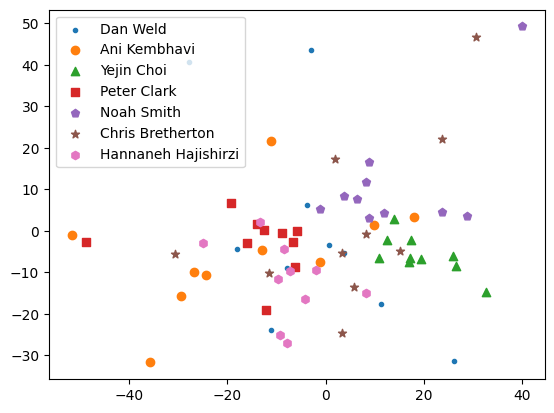

In [4]:
from sklearn import manifold

import matplotlib.pyplot as plt
import numpy

t_sne = manifold.TSNE(
    n_components=2,
    perplexity=5,
    init="random",
    n_iter=250,
    random_state=0,
)

by_author = {}
for p in papers:
    for n in p["names"]:
        if n not in by_author:
            by_author[n] = []
        if len(p["embedding"]) > 0:
            by_author[n].append(p["embedding"])
    
fig, ax = plt.subplots()
m = [".", "o", "^", "s", "p", "*", "h", "+", "x", "D"]
    
for (i, (name, paper_embeddings)) in tqdm(enumerate(by_author.items())):    
    sne = t_sne.fit_transform(numpy.array(paper_embeddings))
    x, y = sne.T
    ax.scatter(x, y, label=name, marker=m[i % len(m)])

plt.legend()
plt.show()

There's clearly some patterns there we could dig into more there, both to understand what's similar and what the outliers are. Let us know if you do so :)

### That's all (for now)!

This was fun. We hope you enjoyed it to, and that the resulting list(s) of papers are useful for your work.

If you find this type of thing interesting, definitely look into [Semantic Scholar's Academic Graph API](https://www.semanticscholar.org/product/api). We're investing heavily in that direction, and look forward to enabling lots of interesting downstream things.

We're also [hiring](https://allenai.org/careers#current-openings-ai2). If you like problems like these, and want to put your energy towards AI for the common good. Join us!